# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

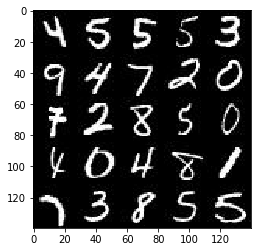

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

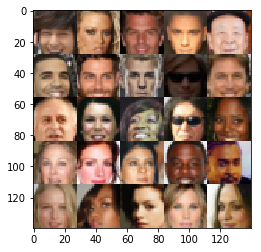

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/josh/anaconda3/envs/dl2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [227]:
from tensorflow.python.layers import utils


d_filters = [64, 128, 256]
d_kernels = [5, 5, 5]
d_strides = [2, 2, 2]
d_padding = ['same', 'same', 'same']
w = 28
print("{}x{}x{}".format(w,w,'channels'))
for f, k, s, p in zip(d_filters, d_kernels, d_strides, d_padding):
    print("  conv2d(x, {}, {}, strides={}, padding={})".format(f, k, s, p))
    w = utils.conv_output_length(w, k, p, s)
    print("{}x{}x{}".format(w,w,f))

28x28xchannels
  conv2d(x, 64, 5, strides=2, padding=same)
14x14x64
  conv2d(x, 128, 5, strides=2, padding=same)
7x7x128
  conv2d(x, 256, 5, strides=2, padding=same)
4x4x256


In [228]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):        
        x = tf.layers.conv2d(images, 
                             d_filters[0], 
                             d_kernels[0], 
                             strides=d_strides[0], 
                             padding=d_padding[0], 
                             activation=None)
        x = tf.maximum(0.2*x, x)
        
        # build convolutional layers using helper above
        for f, k, s, p in zip(d_filters[1:], d_kernels[1:], d_strides[1:], d_padding[1:]):
            x = tf.layers.conv2d(x, f, k, strides=s, padding=p, activation=None)
            x = tf.layers.batch_normalization(x, training=True)
            x = tf.maximum(0.2*x, x)
        
        # Flatten and generate logits and softmax
        x = tf.layers.flatten(x)
        logits = tf.layers.dense(x, 1, activation=None)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [229]:
first_layer_size = 3
dense_size = 1024

g_filters = [512, 256, 128, 'channels']
g_kernels = [5, 5, 5, 3]
g_strides = [1, 2, 2, 1]
g_padding = ['valid', 'same', 'same', 'same']

# g_filters = [256, 128, 'channels']
# g_kernels = [5, 5, 5]
# g_strides = [2, 2, 2]
# g_padding = ['valid', 'same', 'same']

print('z_dim')
print("  Dense layer with {} neurons and reshape to:".format(first_layer_size*first_layer_size*dense_size))
print("{}x{}x{}".format(first_layer_size,first_layer_size,dense_size))

w = first_layer_size
for f, k, s, p in zip(g_filters, g_kernels, g_strides, g_padding):
    print("  conv2d_transpose(x, {}, {}, strides={}, padding={})".format(f, k, s, p))
    w = utils.deconv_output_length(w, k, p, s)
    print("{}x{}x{}".format(w,w,f))

z_dim
  Dense layer with 9216 neurons and reshape to:
3x3x1024
  conv2d_transpose(x, 512, 5, strides=1, padding=valid)
7x7x512
  conv2d_transpose(x, 256, 5, strides=2, padding=same)
14x14x256
  conv2d_transpose(x, 128, 5, strides=2, padding=same)
28x28x128
  conv2d_transpose(x, channels, 3, strides=1, padding=same)
28x28xchannels


In [230]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope("generator", reuse=not is_train):
        # vector -> 3x3
        x = tf.layers.dense(z, first_layer_size*first_layer_size*dense_size)
        x = tf.reshape(x, (-1, first_layer_size, first_layer_size, dense_size))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(0.2*x, x)
#         x = tf.nn.relu(x)

        # Build layers using helper above
        for f, k, s, p in zip(g_filters[:-1], g_kernels[:-1], g_strides[:-1], g_padding[:-1]):
            x = tf.layers.conv2d_transpose(x, f, k, strides=s, padding=p, activation=None)
            x = tf.layers.batch_normalization(x, training=is_train)
            x = tf.maximum(0.2*x, x)
#             x = tf.nn.relu(x)

        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 
                                            g_kernels[-1], 
                                            strides=g_strides[-1], 
                                            padding=g_padding[-1], 
                                            activation=None)
        out = tf.nn.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [231]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    smooth = 0.1
    
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True)

    real_labels = tf.ones_like(d_model_real)
    fake_labels = tf.zeros_like(d_model_fake)
    
    # Discriminator loss on real images
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                    labels=(1-smooth) * real_labels))
    
    # Discriminator loss on fake images
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=fake_labels))
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=real_labels))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [232]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    d_vars = tf.trainable_variables(scope='discriminator')
    g_vars = tf.trainable_variables(scope='generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [233]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [234]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    plot_every = 100
    
    # Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_i = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Rescale data range from +/-0.5 to +/-1.0
                batch_images *= 2
                
                z_batch = np.random.uniform(-1.0, 1.0, [batch_size, z_dim])
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: z_batch, 
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: z_batch, 
                                                     lr: learning_rate})
                
                # Print training loss
                if batch_i%print_every == 0:
                    training_d_loss = d_loss.eval({input_real: batch_images, input_z: z_batch})
                    training_g_loss = g_loss.eval({input_real: batch_images, input_z: z_batch})
                    print("Epoch {}/{:<8d} d_loss {:<8.4f} g_loss {:<8.4f}".format(epoch_i+1, 
                                                                                   epoch_count,
                                                                                   training_d_loss, 
                                                                                   training_g_loss))
                
                # Show generator output
                if batch_i%plot_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[-1], data_image_mode)
                batch_i += 1
        
        # Final generator result
        show_generator_output(sess, batch_size, input_z, data_shape[-1], data_image_mode)

In [235]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("MNIST Data shape:", mnist_dataset.shape)
batch_gen = mnist_dataset.get_batches(10)
test_batch = next(batch_gen)
print("data range: {:.1f} to {:.1f}".format(np.min(test_batch), np.max(test_batch)))
print("tanh range: {:.1f} to {:.1f}".format(np.tanh(-10), np.tanh(10)))

MNIST Data shape: (60000, 28, 28, 1)
data range: -0.5 to 0.5
tanh range: -1.0 to 1.0


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2        d_loss 23.7070  g_loss 0.0000  


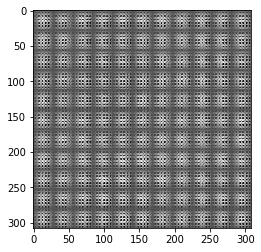

Epoch 1/2        d_loss 6.1379   g_loss 0.0037  
Epoch 1/2        d_loss 0.7685   g_loss 3.7810  
Epoch 1/2        d_loss 0.6527   g_loss 4.0718  
Epoch 1/2        d_loss 0.3607   g_loss 4.3273  


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [205]:
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("CelebA Data shape:", celeba_dataset.shape)
batch_gen = celeba_dataset.get_batches(10)
test_batch = next(batch_gen)
print("data range: {:.1f} to {:.1f}".format(np.min(test_batch), np.max(test_batch)))
print("tanh range: {:.1f} to {:.1f}".format(np.tanh(-10), np.tanh(10)))

CelebA Data shape: (202599, 28, 28, 3)
data range: -0.5 to 0.5
tanh range: -1.0 to 1.0


Epoch 1/1        d_loss 13.8144  g_loss 0.0000  


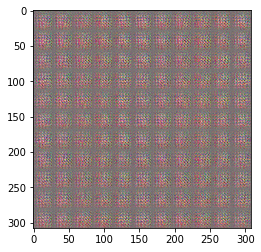

Epoch 1/1        d_loss 0.5184   g_loss 7.0309  
Epoch 1/1        d_loss 0.8567   g_loss 1.2459  
Epoch 1/1        d_loss 0.5312   g_loss 4.6990  
Epoch 1/1        d_loss 0.6851   g_loss 1.3596  
Epoch 1/1        d_loss 0.4898   g_loss 12.8110 
Epoch 1/1        d_loss 0.5006   g_loss 3.3926  
Epoch 1/1        d_loss 0.8605   g_loss 1.5387  
Epoch 1/1        d_loss 1.6616   g_loss 10.6458 
Epoch 1/1        d_loss 0.8219   g_loss 1.9768  
Epoch 1/1        d_loss 1.5159   g_loss 0.6066  


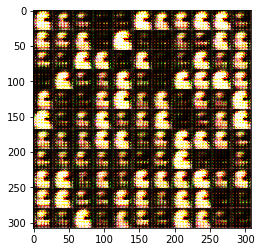

Epoch 1/1        d_loss 1.2419   g_loss 5.8288  
Epoch 1/1        d_loss 0.8932   g_loss 1.1121  
Epoch 1/1        d_loss 0.5900   g_loss 2.0019  
Epoch 1/1        d_loss 3.1917   g_loss 11.4352 
Epoch 1/1        d_loss 0.7578   g_loss 1.9154  
Epoch 1/1        d_loss 0.6593   g_loss 2.2820  
Epoch 1/1        d_loss 0.8994   g_loss 1.3362  
Epoch 1/1        d_loss 0.7273   g_loss 1.8543  
Epoch 1/1        d_loss 1.6312   g_loss 5.4296  
Epoch 1/1        d_loss 1.1975   g_loss 0.6849  


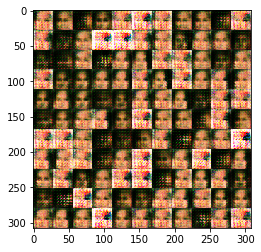

Epoch 1/1        d_loss 0.7354   g_loss 1.5862  
Epoch 1/1        d_loss 1.0062   g_loss 2.3466  
Epoch 1/1        d_loss 1.0937   g_loss 1.1213  
Epoch 1/1        d_loss 0.7693   g_loss 2.1096  
Epoch 1/1        d_loss 1.2912   g_loss 0.7095  
Epoch 1/1        d_loss 0.9952   g_loss 1.3608  
Epoch 1/1        d_loss 1.3107   g_loss 1.2031  
Epoch 1/1        d_loss 0.8741   g_loss 1.5677  
Epoch 1/1        d_loss 1.1119   g_loss 2.1114  
Epoch 1/1        d_loss 1.0754   g_loss 1.2924  


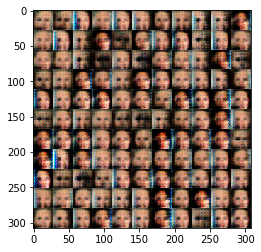

Epoch 1/1        d_loss 1.2409   g_loss 0.7595  
Epoch 1/1        d_loss 1.0781   g_loss 1.1764  
Epoch 1/1        d_loss 1.3786   g_loss 1.0281  
Epoch 1/1        d_loss 1.0625   g_loss 0.9822  
Epoch 1/1        d_loss 1.4072   g_loss 1.1816  
Epoch 1/1        d_loss 0.9542   g_loss 1.6137  
Epoch 1/1        d_loss 1.8432   g_loss 0.3901  
Epoch 1/1        d_loss 0.8093   g_loss 1.3410  
Epoch 1/1        d_loss 1.2573   g_loss 0.8833  
Epoch 1/1        d_loss 0.9491   g_loss 1.2923  


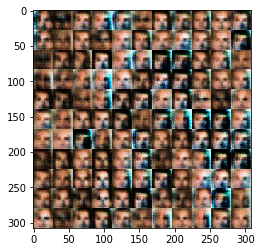

Epoch 1/1        d_loss 1.3731   g_loss 1.4831  
Epoch 1/1        d_loss 0.7445   g_loss 3.0291  
Epoch 1/1        d_loss 1.3598   g_loss 1.0321  
Epoch 1/1        d_loss 1.8451   g_loss 0.6068  
Epoch 1/1        d_loss 1.0461   g_loss 1.0340  
Epoch 1/1        d_loss 0.8975   g_loss 1.2218  
Epoch 1/1        d_loss 1.5286   g_loss 1.6490  
Epoch 1/1        d_loss 1.0190   g_loss 1.4359  
Epoch 1/1        d_loss 1.0992   g_loss 2.0610  
Epoch 1/1        d_loss 0.8413   g_loss 1.6036  


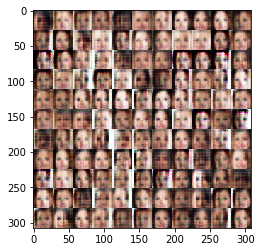

Epoch 1/1        d_loss 1.0337   g_loss 2.5905  
Epoch 1/1        d_loss 0.9059   g_loss 1.4375  
Epoch 1/1        d_loss 1.2398   g_loss 0.8906  
Epoch 1/1        d_loss 0.9660   g_loss 1.5059  
Epoch 1/1        d_loss 0.7390   g_loss 1.7803  
Epoch 1/1        d_loss 1.3257   g_loss 0.6297  
Epoch 1/1        d_loss 1.3204   g_loss 0.9264  
Epoch 1/1        d_loss 0.9223   g_loss 1.2407  
Epoch 1/1        d_loss 1.0438   g_loss 0.9024  
Epoch 1/1        d_loss 1.1011   g_loss 0.8800  


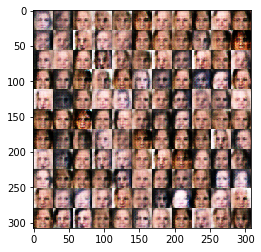

Epoch 1/1        d_loss 0.9685   g_loss 1.3196  
Epoch 1/1        d_loss 1.0581   g_loss 0.8543  
Epoch 1/1        d_loss 1.3127   g_loss 1.9634  
Epoch 1/1        d_loss 1.0761   g_loss 1.2783  
Epoch 1/1        d_loss 1.0328   g_loss 0.9582  
Epoch 1/1        d_loss 1.0546   g_loss 1.0517  
Epoch 1/1        d_loss 1.1393   g_loss 0.8188  
Epoch 1/1        d_loss 1.7487   g_loss 2.3072  
Epoch 1/1        d_loss 1.1439   g_loss 1.8710  
Epoch 1/1        d_loss 1.4083   g_loss 1.5786  


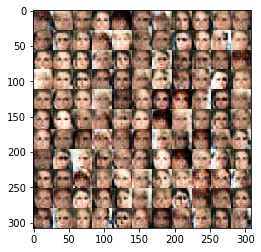

Epoch 1/1        d_loss 0.9542   g_loss 1.2436  
Epoch 1/1        d_loss 0.9785   g_loss 1.1553  
Epoch 1/1        d_loss 1.1036   g_loss 0.8628  
Epoch 1/1        d_loss 0.9735   g_loss 1.1600  
Epoch 1/1        d_loss 1.1007   g_loss 2.2318  
Epoch 1/1        d_loss 1.1325   g_loss 1.3292  
Epoch 1/1        d_loss 1.1263   g_loss 1.2856  
Epoch 1/1        d_loss 1.1731   g_loss 1.0806  
Epoch 1/1        d_loss 1.1683   g_loss 1.2463  
Epoch 1/1        d_loss 1.0880   g_loss 1.0493  


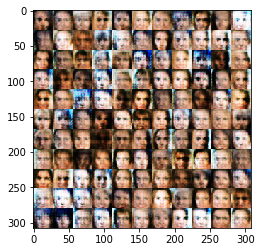

Epoch 1/1        d_loss 1.4201   g_loss 0.5425  
Epoch 1/1        d_loss 1.0091   g_loss 1.6072  
Epoch 1/1        d_loss 0.8714   g_loss 1.3809  
Epoch 1/1        d_loss 1.2803   g_loss 0.7413  
Epoch 1/1        d_loss 0.9491   g_loss 1.4553  
Epoch 1/1        d_loss 1.2205   g_loss 1.1039  
Epoch 1/1        d_loss 1.0359   g_loss 1.2354  
Epoch 1/1        d_loss 1.2369   g_loss 2.0265  
Epoch 1/1        d_loss 1.1354   g_loss 1.8277  
Epoch 1/1        d_loss 0.9599   g_loss 1.1873  


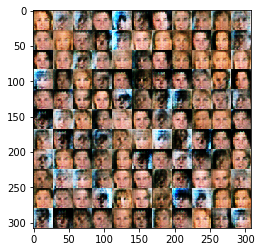

Epoch 1/1        d_loss 1.1633   g_loss 0.9295  
Epoch 1/1        d_loss 1.2161   g_loss 1.2607  
Epoch 1/1        d_loss 1.5124   g_loss 0.5899  
Epoch 1/1        d_loss 1.1441   g_loss 0.7869  
Epoch 1/1        d_loss 0.9712   g_loss 1.7855  
Epoch 1/1        d_loss 1.1067   g_loss 1.1290  
Epoch 1/1        d_loss 0.9165   g_loss 1.2916  
Epoch 1/1        d_loss 1.1466   g_loss 1.5189  
Epoch 1/1        d_loss 1.2414   g_loss 1.1256  
Epoch 1/1        d_loss 1.0516   g_loss 1.0948  


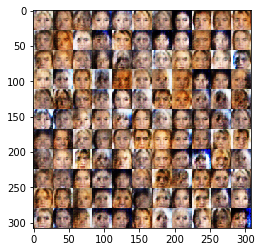

Epoch 1/1        d_loss 1.0876   g_loss 0.9580  
Epoch 1/1        d_loss 0.9926   g_loss 1.5006  
Epoch 1/1        d_loss 1.0257   g_loss 1.3246  
Epoch 1/1        d_loss 1.1028   g_loss 1.1920  
Epoch 1/1        d_loss 0.9877   g_loss 2.3496  
Epoch 1/1        d_loss 1.1564   g_loss 1.0315  
Epoch 1/1        d_loss 1.3895   g_loss 2.2605  
Epoch 1/1        d_loss 1.0306   g_loss 1.0434  
Epoch 1/1        d_loss 0.9687   g_loss 1.6669  
Epoch 1/1        d_loss 1.1028   g_loss 2.2484  


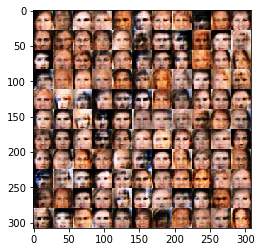

Epoch 1/1        d_loss 1.0131   g_loss 1.5140  
Epoch 1/1        d_loss 1.1356   g_loss 1.7682  
Epoch 1/1        d_loss 1.2381   g_loss 1.0009  
Epoch 1/1        d_loss 2.0029   g_loss 0.2821  
Epoch 1/1        d_loss 1.1876   g_loss 1.2541  
Epoch 1/1        d_loss 1.1525   g_loss 1.4020  
Epoch 1/1        d_loss 1.1499   g_loss 1.0413  
Epoch 1/1        d_loss 1.0108   g_loss 1.5456  
Epoch 1/1        d_loss 0.9298   g_loss 1.8922  
Epoch 1/1        d_loss 1.2455   g_loss 1.2072  


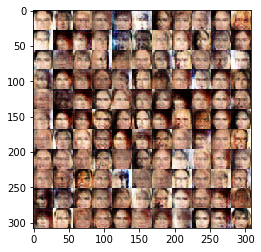

Epoch 1/1        d_loss 1.0874   g_loss 0.8274  
Epoch 1/1        d_loss 1.2518   g_loss 0.6763  
Epoch 1/1        d_loss 1.1361   g_loss 1.1804  
Epoch 1/1        d_loss 1.0597   g_loss 1.1506  
Epoch 1/1        d_loss 1.2884   g_loss 1.9412  
Epoch 1/1        d_loss 1.4408   g_loss 0.5102  
Epoch 1/1        d_loss 1.0659   g_loss 0.8957  
Epoch 1/1        d_loss 1.0723   g_loss 0.8887  
Epoch 1/1        d_loss 0.9950   g_loss 1.0599  
Epoch 1/1        d_loss 1.1698   g_loss 2.2492  


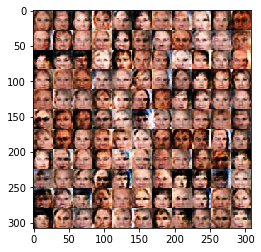

Epoch 1/1        d_loss 1.0800   g_loss 1.3291  
Epoch 1/1        d_loss 0.9241   g_loss 1.3175  
Epoch 1/1        d_loss 1.5503   g_loss 0.4541  
Epoch 1/1        d_loss 1.1225   g_loss 1.1909  
Epoch 1/1        d_loss 1.2293   g_loss 0.8946  
Epoch 1/1        d_loss 1.0876   g_loss 1.7325  
Epoch 1/1        d_loss 1.0142   g_loss 1.2588  
Epoch 1/1        d_loss 1.1928   g_loss 0.8607  
Epoch 1/1        d_loss 0.9807   g_loss 1.5133  
Epoch 1/1        d_loss 0.9604   g_loss 1.3434  


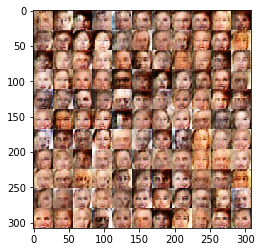

Epoch 1/1        d_loss 1.1229   g_loss 1.4365  
Epoch 1/1        d_loss 1.0342   g_loss 1.2304  
Epoch 1/1        d_loss 1.2366   g_loss 0.6929  
Epoch 1/1        d_loss 0.9751   g_loss 1.2021  
Epoch 1/1        d_loss 0.9913   g_loss 1.1786  
Epoch 1/1        d_loss 1.0473   g_loss 1.2706  
Epoch 1/1        d_loss 1.4096   g_loss 0.5754  
Epoch 1/1        d_loss 1.1269   g_loss 1.1767  
Epoch 1/1        d_loss 1.1183   g_loss 0.9720  
Epoch 1/1        d_loss 1.1543   g_loss 2.1310  


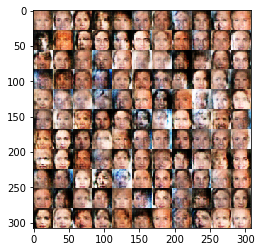

Epoch 1/1        d_loss 1.0648   g_loss 1.8835  
Epoch 1/1        d_loss 1.0797   g_loss 1.0963  
Epoch 1/1        d_loss 1.0892   g_loss 1.2180  
Epoch 1/1        d_loss 1.2166   g_loss 1.6237  
Epoch 1/1        d_loss 1.5997   g_loss 0.4227  
Epoch 1/1        d_loss 1.1463   g_loss 0.8296  
Epoch 1/1        d_loss 1.1324   g_loss 1.4797  
Epoch 1/1        d_loss 1.4982   g_loss 0.5415  


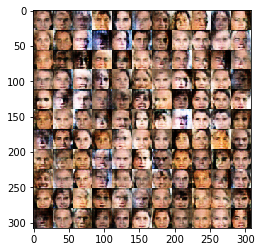

In [206]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.